# Eclipse of 1919 MCMC and HMC exercise

Florent Leclercq<br>
Imperial Centre for Inference and Cosmology, Imperial College London<br>
<a href="mailto:florent.leclercq@polytechnique.org">florent.leclercq@polytechnique.org</a>

In [1]:
import numpy as np
import scipy
import scipy.stats as ss
import matplotlib.pyplot as plt
np.random.seed(3)

In [2]:
# Some plotting tools and routines

nBins = 30
nContourLevels = 3
# 2d contour levels: (68%, 95%, 99%)
confLevels = [.3173, .0455, .0027]
smoothingKernel = 1

def get_marginal(samples):
    # create 1d histogram
    hist1d, edges = np.histogram(samples, weights=np.ones_like(samples),
        density=True, bins=nBins)

    # Bin center between histogram edges
    centers = (edges[1:]+edges[:-1])/2

    # Filter data
    pdf = np.array((centers, hist1d))
    pdf = scipy.ndimage.gaussian_filter1d(pdf, sigma=smoothingKernel)

    # Clip the pdf to zero out of the bins
    centers, hist = pdf[0], pdf[1]
    centers = np.insert(centers, 0, centers[0]-(centers[1]-centers[0]))
    hist = np.insert(hist, 0, 0.)
    centers = np.insert(centers, len(centers), centers[len(centers)-1]-(centers[len(centers)-2]-centers[len(centers)-1]))
    hist = np.insert(hist, len(hist), 0.)

    # Normalize all the pdfs to the same height
    hist /= hist.max()

    pdf = np.array((centers, hist))
    
    return pdf

def get_contours(samples_x, samples_y):
    # Empty arrays needed below
    chainLevels = np.ones(nContourLevels+1)
    extents = np.empty(4)

    # These are needed to compute the contour levels
    nBinsFlat = np.linspace(0., nBins**2, nBins**2)

    # Create 2d histogram
    hist2d, xedges, yedges = np.histogram2d(
        samples_x, samples_y, weights=np.ones_like(samples_x), bins=nBins)
    # image extent, needed below for contour lines
    extents = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Normalize
    hist2d = hist2d/np.sum(hist2d)
    # Cumulative 1d distribution
    histOrdered = np.sort(hist2d.flat)
    histCumulative = np.cumsum(histOrdered)

    # Compute contour levels (from low to high for technical reasons)
    for l in range(nContourLevels):
        # Find location of contour level in 1d histCumulative
        temp = np.interp(confLevels[l], histCumulative, nBinsFlat)
        # Find "height" of contour level
        chainLevels[nContourLevels-1-l] = np.interp(temp, nBinsFlat, histOrdered)

    # Apply Gaussian smoothing
    contours = scipy.ndimage.gaussian_filter(hist2d.T, sigma=smoothingKernel)

    xbins = (xedges[1:]+xedges[:-1])/2
    ybins = (yedges[1:]+yedges[:-1])/2
    
    return xbins, ybins, contours, chainLevels

## Data model

In [3]:
def Dx_11(alpha,a,b,c):
    return c-0.160*b-1.261*a-0.587*alpha/19.8
def Dx_5(alpha,a,b,c):
    return c-1.107*b-0.160*a-0.557*alpha/19.8
def Dx_4(alpha,a,b,c):
    return c+0.472*b+0.334*a-0.186*alpha/19.8
def Dx_3(alpha,a,b,c):
    return c+0.360*b+0.348*a-0.222*alpha/19.8
def Dx_6(alpha,a,b,c):
    return c+1.099*b+0.587*a+0.080*alpha/19.8
def Dx_10(alpha,a,b,c):
    return c+1.321*b+0.860*a+0.158*alpha/19.8
def Dx_2(alpha,a,b,c):
    return c-0.328*b+1.079*a+1.540*alpha/19.8

def Dy_11(alpha,d,e,f):
    return f-1.261*d-0.160*e+0.036*alpha/19.8
def Dy_5(alpha,d,e,f):
    return f-0.160*d-1.107*e-0.789*alpha/19.8
def Dy_4(alpha,d,e,f):
    return f+0.334*d+0.472*e+1.336*alpha/19.8
def Dy_3(alpha,d,e,f):
    return f+0.348*d+0.360*e+1.574*alpha/19.8
def Dy_6(alpha,d,e,f):
    return f+0.587*d+1.099*e+0.726*alpha/19.8
def Dy_10(alpha,d,e,f):
    return f+0.860*d+1.321*e+0.589*alpha/19.8
def Dy_2(alpha,d,e,f):
    return f+1.079*d-0.328*e-0.156*alpha/19.8

stars = np.array([11,5,4,3,6,10,2])
alpha_GR=1.75
alpha_Newton=0.9

## Simulations

In [4]:
nsims=10
a=ss.uniform(-1.,2.).rvs(nsims)
b=ss.uniform(-1.,2.).rvs(nsims)
c=ss.uniform(-1.,2.).rvs(nsims)
d=ss.uniform(-1.,2.).rvs(nsims)
e=ss.uniform(-1.,2.).rvs(nsims)
f=ss.uniform(-1.,2.).rvs(nsims)
alpha=ss.uniform(-0.75,2+0.75).rvs(nsims)

sims_x = np.array([
            Dx_11(alpha,a,b,c),
            Dx_5(alpha,a,b,c),
            Dx_4(alpha,a,b,c),
            Dx_3(alpha,a,b,c),
            Dx_6(alpha,a,b,c),
            Dx_10(alpha,a,b,c),
            Dx_2(alpha,a,b,c)
])
sims_y = np.array([
            Dy_11(alpha,d,e,f),
            Dy_5(alpha,d,e,f),
            Dy_4(alpha,d,e,f),
            Dy_3(alpha,d,e,f),
            Dy_6(alpha,d,e,f),
            Dy_10(alpha,d,e,f),
            Dy_2(alpha,d,e,f)
])

## Data vectors

In [5]:
dx_I = np.array([
       -1.411+1.500,
       -1.048+1.500,
       -1.216+1.500,
       -1.237+1.500,
       -1.342+1.500,
       -1.289+1.500,
       -0.789+1.500,
])
dy_I = np.array([
       -0.554+0.554,
       -0.338+0.554,
       +0.114+0.554,
       +0.150+0.554,
       +0.124+0.554,
       +0.205+0.554,
       +0.109+0.554,
])
dx_II = np.array([
       -1.416+1.500,
       -1.221+1.500,
       -1.054+1.500,
       -1.079+1.500,
       -1.012+1.500,
       -0.999+1.500,
       -0.733+1.500,
])
dy_II = np.array([
       -1.324+1.324,
       -1.312+1.324,
       -0.944+1.324,
       -0.862+1.324,
       -0.932+1.324,
       -0.948+1.324,
       -1.019+1.324,
])
dx_III = np.array([
       +0.592-0.500,
       +0.756-0.500,
       +0.979-0.500,
       +0.958-0.500,
       +1.052-0.500,
       +1.157-0.500,
       +1.256-0.500,
])
dy_III = np.array([
       +0.956-0.843,
       +0.843-0.843,
       +1.172-0.843,
       +1.244-0.843,
       +1.197-0.843,
       +1.211-0.843,
       +0.924-0.843,
])
dx_IV = np.array([
       +0.563-0.500,
       +0.683-0.500,
       +0.849-0.500,
       +0.861-0.500,
       +0.894-0.500,
       +0.934-0.500,
       +1.177-0.500,
])
dy_IV = np.array([
       +1.238-1.226,
       +1.226-1.226,
       +1.524-1.226,
       +1.587-1.226,
       +1.564-1.226,
       +1.522-1.226,
       +1.373-1.226,
])
dx_V = np.array([
       +0.406-0.400,
       +0.468-0.400,
       +0.721-0.400,
       +0.733-0.400,
       +0.798-0.400,
       +0.864-0.400,
       +0.995-0.400,
])
dy_V = np.array([
       +0.970-0.861,
       +0.861-0.861,
       +1.167-0.861,
       +1.234-0.861,
       +1.130-0.861,
       +1.119-0.861,
       +0.935-0.861,
])
# Plate VI was not used!
dx_VII = np.array([
       -1.456+1.500,
       -1.267+1.500,
       -1.028+1.500,
       -1.010+1.500,
       -0.888+1.500,
       -0.820+1.500,
       -0.768+1.500,
])
dy_VII = np.array([
       +0.964-0.777,
       +0.777-0.777,
       +1.142-0.777,
       +1.185-0.777,
       +1.125-0.777,
       +1.072-0.777,
       +0.892-0.777,
])
dx_VIII = np.array([
       -1.285+1.300,
       -1.152+1.300,
       -0.927+1.300,
       -0.897+1.300,
       -0.838+1.300,
       -0.768+1.300,
       -0.585+1.300,
])
dy_VIII = np.array([
       -1.195+1.322,
       -1.332+1.322,
       -0.930+1.322,
       -0.894+1.322,
       -0.937+1.322,
       -0.964+1.322,
       -1.166+1.322,
])

# Assumed error on the measurements
sigma_d = 0.05

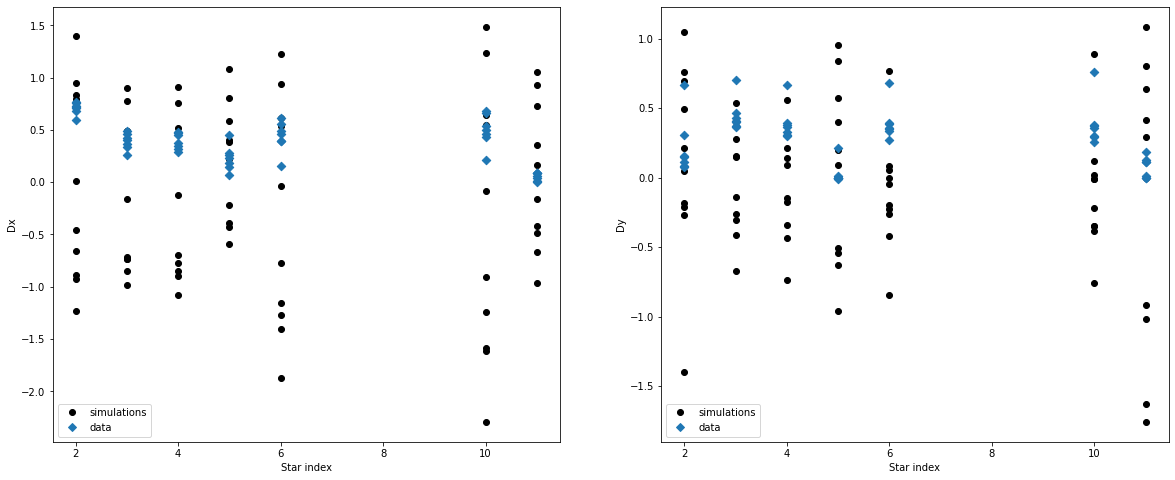

In [6]:
from matplotlib.lines import Line2D

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))

for i, star in enumerate(stars):
    ax0.scatter(star*np.ones(nsims),sims_x[i],marker="o",color="black")
for dx in [dx_I,dx_II,dx_III,dx_IV,dx_V,dx_VII,dx_VIII]:
    ax0.scatter(stars,dx,color="C0",marker="D")
ax0.set_xlabel("Star index")
ax0.set_ylabel("Dx")
legend_elements = [Line2D([0], [0], lw=0, marker="o", color="black", label="simulations"),
                   Line2D([0], [0], lw=0, marker="D", color="C0", label="data"),
                  ]
ax0.legend(handles=legend_elements)

for i, star in enumerate(stars):
    ax1.scatter(star*np.ones(nsims),sims_y[i],marker="o",color="black")
for dy in [dy_I,dy_II,dy_III,dy_IV,dy_V,dy_VII,dy_VIII]:
    ax1.scatter(stars,dy,color="C0",marker="D")
ax1.set_xlabel("Star index")
ax1.set_ylabel("Dy")
ax1.legend(handles=legend_elements)

## Log-likelihood

In [7]:
def lh_platex_logpdf(theta,data,sigma_d):
    alpha,a,b,c = theta[0],theta[1],theta[2],theta[3]
    theory = np.array([
            Dx_11(alpha,a,b,c),
            Dx_5(alpha,a,b,c),
            Dx_4(alpha,a,b,c),
            Dx_3(alpha,a,b,c),
            Dx_6(alpha,a,b,c),
            Dx_10(alpha,a,b,c),
            Dx_2(alpha,a,b,c)
    ])
    return -1/2.*np.sum((theory-data)**2/sigma_d**2)

def lh_platey_logpdf(theta,data,sigma_d):
    alpha,d,e,f = theta[0],theta[1],theta[2],theta[3]
    theory = np.array([
            Dy_11(alpha,d,e,f),
            Dy_5(alpha,d,e,f),
            Dy_4(alpha,d,e,f),
            Dy_3(alpha,d,e,f),
            Dy_6(alpha,d,e,f),
            Dy_10(alpha,d,e,f),
            Dy_2(alpha,d,e,f)
    ])
    # Note that the second term is not relevant for MCMC, only for model comparison
    return -1/2.*np.sum((theory-data)**2/sigma_d**2) - (np.sqrt(2*np.pi)*sigma_d)**theory.shape[0]

def target_logpdf(theta,data,sigma_d):
    return lh_platex_logpdf(theta,data,sigma_d)

In [8]:
lh_platex_logpdf([1.7,0.,0.,0.],[dx_I,dx_II],sigma_d), lh_platey_logpdf([0.9,0.1,-0.1,0.05],[dy_III,dy_V],sigma_d)

(-447.91366343851735, -133.8783688163361)

## Metropolis-Hastings sampler

In [9]:
def uniform_proposal_pdf(proposal_cov):
    sigmas=np.sqrt(np.diag(proposal_cov))
    return ss.uniform(loc=-sigmas*np.sqrt(3), scale=2*sigmas*np.sqrt(3))

def gaussian_proposal_pdf(proposal_cov):
    return ss.multivariate_normal(np.zeros(proposal_cov.shape[0]),proposal_cov)

def proposal_pdf(proposal_cov):
#     return uniform_proposal_pdf(proposal_cov)
    return gaussian_proposal_pdf(proposal_cov)

In [10]:
def MH_sampler(Ntries,theta_start,data,sigma_d,proposal_cov):
    Naccepted=0
    samples=list()
    samples.append(theta_start)
    theta=theta_start
    for i in range(Ntries):
        theta_p = theta + proposal_pdf(proposal_cov).rvs()
        # the uniform/Gaussian proposal pdf satisfies the detailed balance equation, so the
        # acceptance ratio simplifies to the Metropolis ratio
        a = min(1, np.exp(target_logpdf(theta_p,data,sigma_d) - target_logpdf(theta,data,sigma_d)))
        u = ss.uniform().rvs()
        if u < a:
            Naccepted+=1
            theta=theta_p
        samples.append(theta)
    return Naccepted, np.array(samples)

In [11]:
Ntries1=1000
Nburnin=100
proposal_sigma=np.array([8e-1,4e-2,2e-2,2e-2])
proposal_cov=np.diag(proposal_sigma**2)
theta_start=np.array([1.75,0.,0.,0.])
Naccepted, samples = MH_sampler(Ntries1,theta_start,[dx_II],sigma_d,proposal_cov)
fraction_accepted=float(Naccepted)/Ntries1

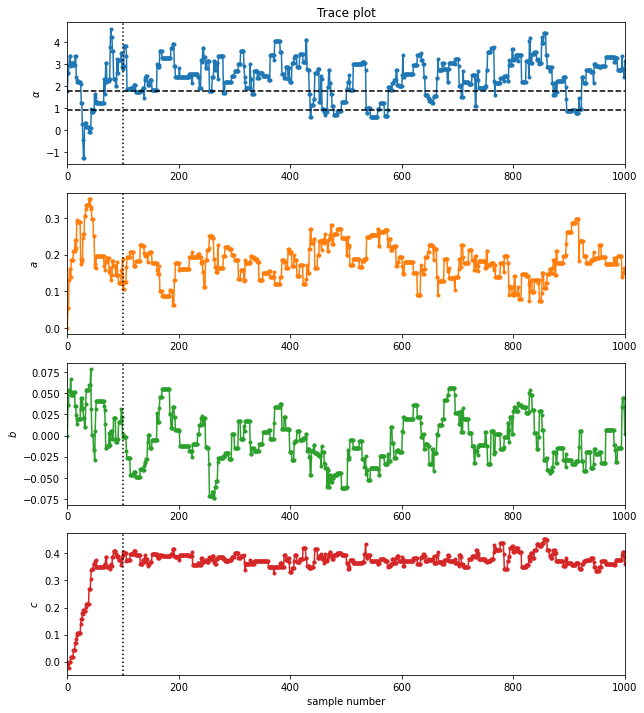

In [12]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(10,12))

ax0.set_xlim(0,Ntries1+1)
ax0.set_title("Trace plot")
ax0.set_ylabel("$\\alpha$")
ax0.plot(np.arange(Ntries1+1),samples.T[0],marker='.',color='C0')
ax0.axhline(alpha_Newton,color='black',linestyle='--')
ax0.axhline(alpha_GR,color='black',linestyle='--')
ax0.axvline(Nburnin,color='black',linestyle=':')

ax1.set_xlim(0,Ntries1+1)
ax1.set_ylabel("$a$")
ax1.plot(np.arange(Ntries1+1),samples.T[1],marker='.',color='C1')
ax1.axvline(Nburnin,color='black',linestyle=':')

ax2.set_xlim(0,Ntries1+1)
ax2.set_ylabel("$b$")
ax2.plot(np.arange(Ntries1+1),samples.T[2],marker='.',color='C2')
ax2.axvline(Nburnin,color='black',linestyle=':')

ax3.set_xlim(0,Ntries1+1)
ax3.set_ylabel("$c$")
ax3.plot(np.arange(Ntries1+1),samples.T[3],marker='.',color='C3')
ax3.set_xlabel("sample number")
ax3.axvline(Nburnin,color='black',linestyle=':')

In [13]:
fraction_accepted

0.29

## Markov chain diagnostics

### 1- Step size

In [14]:
Ntries2=1000
theta_start=np.array([1.75,0.,0.,0.])

In [15]:
# Suitable step size
proposal_sigma_1=np.array([8e-1,4e-2,2e-2,2e-2])
proposal_cov=np.diag(proposal_sigma_1**2)
Naccepted_1, samples_1 = MH_sampler(Ntries2,theta_start,[dx_II],sigma_d,proposal_cov)
fraction_accepted_1=float(Naccepted_1)/Ntries2

In [16]:
# Step size too large
proposal_sigma_2=np.array([1.5,0.2,0.1,0.1])
proposal_cov=np.diag(proposal_sigma_2**2)
Naccepted_2, samples_2 = MH_sampler(Ntries2,theta_start,[dx_II],sigma_d,proposal_cov)
fraction_accepted_2=float(Naccepted_2)/Ntries2

In [17]:
# Step size too small
proposal_sigma_3=np.array([1e-2,2e-3,1e-3,1e-3])
proposal_cov=np.diag(proposal_sigma_3**2)
Naccepted_3, samples_3 = MH_sampler(Ntries2,theta_start,[dx_II],sigma_d,proposal_cov)
fraction_accepted_3=float(Naccepted_3)/Ntries2

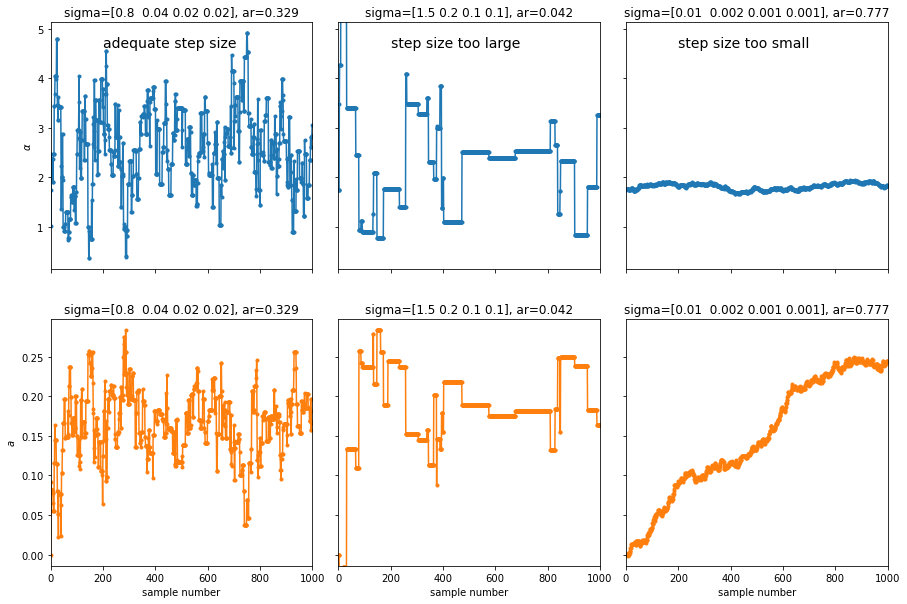

In [18]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,10))

ax1.set_xlim(0,Ntries2)
ax1.set_ylabel("$\\alpha$")
ax1.plot(np.arange(Ntries2+1),samples_1.T[0],marker='.',color='C0')
ymin, ymax = ax1.get_ylim()
ax1.set_title("sigma={}, ar={:.3f}".format(proposal_sigma_1,fraction_accepted_1))
ax2.set_xlim(0,Ntries2)
ax2.set_ylim(ymin,ymax)
ax2.plot(np.arange(Ntries2+1),samples_2.T[0],marker='.',color='C0')
ax2.set_title("sigma={}, ar={:.3f}".format(proposal_sigma_2,fraction_accepted_2))
ax3.set_xlim(0,Ntries2)
ax3.set_ylim(ymin,ymax)
ax3.plot(np.arange(Ntries2+1),samples_3.T[0],marker='.',color='C0')
ax3.set_title("sigma={}, ar={:.3f}".format(proposal_sigma_3,fraction_accepted_3))

ax4.set_xlim(0,Ntries2)
ax4.set_xlabel("sample number")
ax4.set_ylabel("$a$")
ax4.plot(np.arange(Ntries2+1),samples_1.T[1],marker='.',color='C1')
ymin, ymax = ax4.get_ylim()
ax4.set_title("sigma={}, ar={:.3f}".format(proposal_sigma_1,fraction_accepted_1))
ax5.set_xlim(0,Ntries2)
ax5.set_ylim(ymin,ymax)
ax5.set_xlabel("sample number")
ax5.plot(np.arange(Ntries2+1),samples_2.T[1],marker='.',color='C1')
ax5.set_title("sigma={}, ar={:.3f}".format(proposal_sigma_2,fraction_accepted_2))
ax6.set_xlim(0,Ntries2)
ax6.set_ylim(ymin,ymax)
ax6.set_xlabel("sample number")
ax6.plot(np.arange(Ntries2+1),samples_3.T[1],marker='.',color='C1')
ax6.set_title("sigma={}, ar={:.3f}".format(proposal_sigma_3,fraction_accepted_3))

ymin, ymax = ax1.get_ylim()
ax1.text(200,ymax-(ymax-ymin)/10., "adequate step size",fontsize=14)
ax2.text(200,ymax-(ymax-ymin)/10., "step size too large",fontsize=14)
ax3.text(200,ymax-(ymax-ymin)/10., "step size too small",fontsize=14)
f.subplots_adjust(wspace=0.1)

### 2- Multiple chains, different starting points

In [19]:
Ntries3=6000
Nburnin=350
proposal_sigma=np.array([8e-1,4e-2,2e-2,2e-2])
proposal_cov=np.diag(proposal_sigma**2)
Nchains=5

In [20]:
# Run Nchains different chains starting at different positions in parameter space
chains_dx_II = [MH_sampler(Ntries3,theta_start,[dx_II],sigma_d,proposal_cov)
          for theta_start in np.stack((np.linspace(0.,3.,Nchains),
                                       np.linspace(-1.,1.,Nchains),
                                       np.linspace(-1.,1.,Nchains),
                                       np.linspace(-1.,1.,Nchains)),axis=1)]
chain_dx_II = np.array([chains_dx_II[j][1] for j in range(Nchains)])

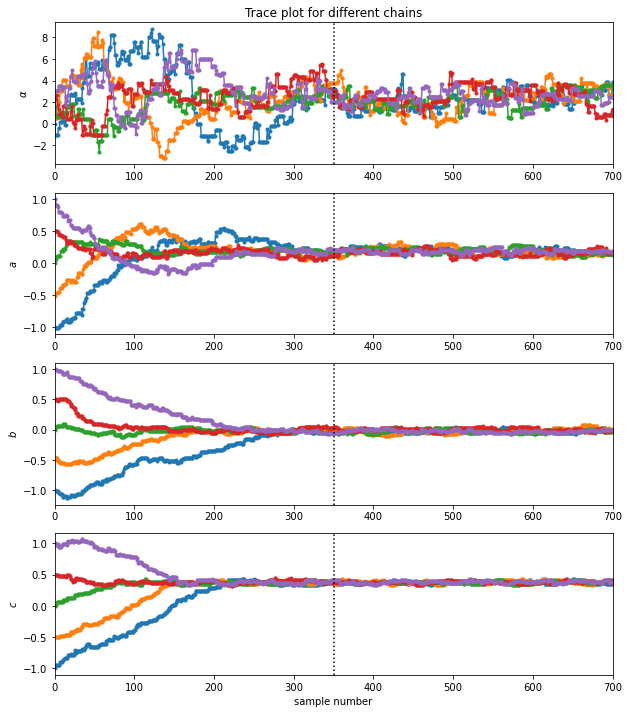

In [21]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(10,12))

ax0.set_xlim(0,700)
ax0.set_ylabel("$\\alpha$")
for samples in chains_dx_II:
    ax0.plot(np.arange(Ntries3+1),samples[1].T[0],marker='.')
ax0.axvline(Nburnin,color='black',linestyle=':')
ax0.set_title("Trace plot for different chains")

ax1.set_xlim(0,700)
ax1.set_ylabel("$a$")
for samples in chains_dx_II:
    ax1.plot(np.arange(Ntries3+1),samples[1].T[1],marker='.')
ax1.axvline(Nburnin,color='black',linestyle=':')

ax2.set_xlim(0,700)
ax2.set_ylabel("$b$")
for samples in chains_dx_II:
    ax2.plot(np.arange(Ntries3+1),samples[1].T[2],marker='.')
ax2.axvline(Nburnin,color='black',linestyle=':')

ax3.set_xlim(0,700)
ax3.set_ylabel("$c$")
ax3.set_xlabel("sample number")
for samples in chains_dx_II:
    ax3.plot(np.arange(Ntries3+1),samples[1].T[3],marker='.')
ax3.axvline(Nburnin,color='black',linestyle=':')

### 3-Gelman-Rubin test

Gelman *et al.*, "*Bayesian Data Analysis*" (third edition), p. 284-285

**Parameters**:
* $m$: number of chains
* $n$: length of chains

**Definitions**:
* "between" chains variance:
\begin{equation}
B \equiv \frac{n}{m-1} \sum_{j=1}^m \left( \bar{\psi}_{. j} - \bar{\psi}_{..} \right)^2 \quad \mathrm{where} \quad \bar{\psi}_{. j} = \frac{1}{n} \sum_{i=1}^n \psi_{ij} \quad \mathrm{and} \quad \bar{\psi}_{..} = \frac{1}{m} \sum_{j=1}^m \bar{\psi}_{.j}
\end{equation}
* "within" chains variance:
\begin{equation}
W \equiv \frac{1}{m} \sum_{j=1}^m s_j^2 \quad \mathrm{where} \quad s_j^2 = \frac{1}{n-1} \sum_{i=1}^n \left( \psi_{ij} - \bar{\psi}_{.j} \right)^2
\end{equation}

**Estimators**:
Estimators of the marginal posterior variance of the estimand:
* $\widehat{\mathrm{var}}^- \equiv W$: underestimates the variance
* $\widehat{\mathrm{var}}^+ \equiv \frac{n}{n-1}W + \frac{1}{n} B$: overestimates the variance

**Test**:
* Potential scale reduction factor: $\widehat{R} \equiv \sqrt{\frac{\widehat{\mathrm{var}}^+}{\widehat{\mathrm{var}}^-}}$
* Test: $\widehat{R} \rightarrow 1$ as $n \rightarrow \infty$

In [22]:
def gelman_rubin(chain):
    # between chains variance
    Psi_dotj = np.mean(chain, axis=1)
    Psi_dotdot = np.mean(Psi_dotj, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1.) * np.sum((Psi_dotj - Psi_dotdot)**2, axis=0)
    
    # within chains variance
    sj2 = np.var(chain, axis=1, ddof=1)
    W = np.mean(sj2, axis=0)
    
    # estimators
    var_minus = W
    var_plus = (n - 1.) / n * W + 1. / n * B
    R_hat = np.sqrt(var_plus / var_minus)
    return R_hat

# The input array must have dimensions (nchains, nsamp, npars) = (m, n, npars).

In [23]:
gelman_rubin(chain_dx_II)

array([1.0015821 , 1.00147765, 1.01366777, 1.01327705])

## Likelihood surface

In [24]:
# Remove burn-in phase
chain_dx_II_burn = np.array([chains_dx_II[j][1][Nburnin:] for j in range(Nchains)])
chain_dx_II_burn_flat = np.concatenate(chain_dx_II_burn, axis=0)

In [25]:
# Means of parameters (alpha, a, b, c)
chain_dx_II_burn.mean(axis=(0,1))

array([ 2.43982644,  0.17707015, -0.01130455,  0.37931725])

In [26]:
# Marginal standard deviations of parameters (alpha, a, b, c)
chain_dx_II_burn.std(axis=(0,1))

array([0.89568493, 0.04645492, 0.02971566, 0.02126872])

In [27]:
# Covariance matrix of parameters (alpha, a, b, c)
np.cov(chain_dx_II_burn_flat.T)

array([[ 8.02279882e-01, -3.23595676e-02,  1.00740663e-02,
         4.74707742e-03],
       [-3.23595676e-02,  2.15813554e-03, -7.52170041e-04,
        -3.19012786e-04],
       [ 1.00740663e-02, -7.52170041e-04,  8.83051942e-04,
        -3.31165625e-05],
       [ 4.74707742e-03, -3.19012786e-04, -3.31165625e-05,
         4.52374539e-04]])

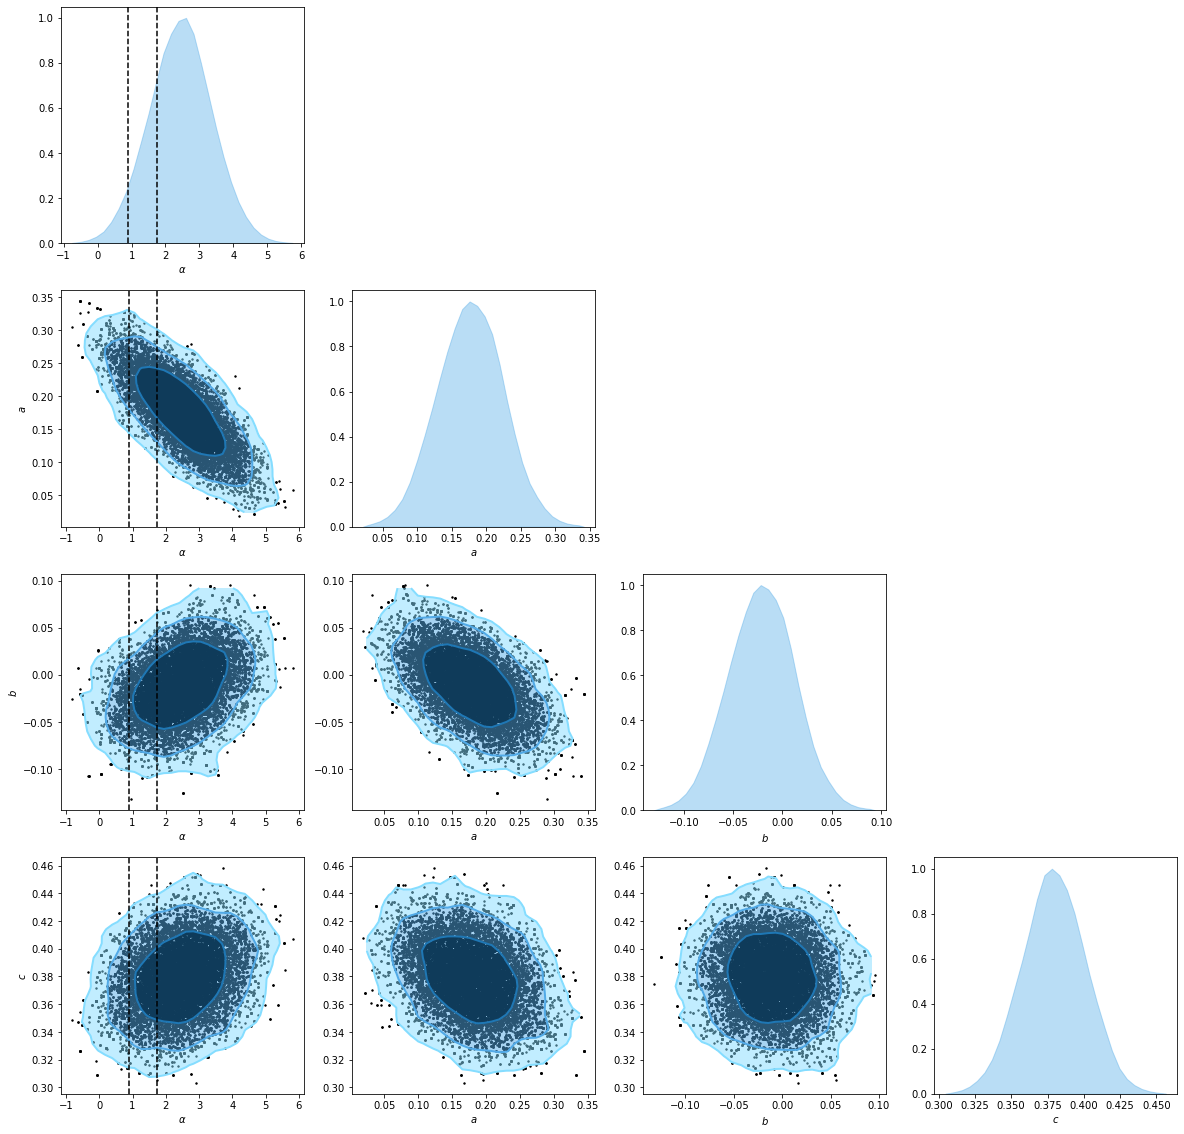

In [28]:
fig = plt.figure(figsize=(20,20))

# Plot 1d marginal distributions
ax0 = fig.add_subplot(4,4,1)
pdf_alpha = get_marginal(chain_dx_II_burn_flat.T[0])
ax0.fill_between(pdf_alpha[0],pdf_alpha[1], 0, color='#52aae7', alpha=0.4)
ax0.set_ylim(0.,pdf_alpha[1].max()*1.05)
ax0.axvline(alpha_GR,color='black',linestyle='--')
ax0.axvline(alpha_Newton,color='black',linestyle='--')
ax0.set_xlabel("$\\alpha$")

ax1 = fig.add_subplot(4,4,6)
pdf_a = get_marginal(chain_dx_II_burn_flat.T[1])
ax1.fill_between(pdf_a[0],pdf_a[1], 0, color='#52aae7', alpha=0.4)
ax1.set_ylim(0.,pdf_a[1].max()*1.05)
ax1.set_xlabel("$a$")

ax2 = fig.add_subplot(4,4,11)
pdf_b = get_marginal(chain_dx_II_burn_flat.T[2])
ax2.fill_between(pdf_b[0],pdf_a[1], 0, color='#52aae7', alpha=0.4)
ax2.set_ylim(0.,pdf_b[1].max()*1.05)
ax2.set_xlabel("$b$")

ax3 = fig.add_subplot(4,4,16)
pdf_c = get_marginal(chain_dx_II_burn_flat.T[3])
ax3.fill_between(pdf_c[0],pdf_c[1], 0, color='#52aae7', alpha=0.4)
ax3.set_ylim(0.,pdf_c[1].max()*1.05)
ax3.set_xlabel("$c$")

# Plot 2d contours
ax0a = fig.add_subplot(4,4,5)
ax0a.scatter(chain_dx_II_burn_flat.T[0], chain_dx_II_burn_flat.T[1], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[0], chain_dx_II_burn_flat.T[1])
ax0a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax0a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax0a.axvline(alpha_GR,color='black',linestyle='--')
ax0a.axvline(alpha_Newton,color='black',linestyle='--')
ax0a.set_xlabel("$\\alpha$")
ax0a.set_ylabel("$a$")

ax1a = fig.add_subplot(4,4,9)
ax1a.scatter(chain_dx_II_burn_flat.T[0], chain_dx_II_burn_flat.T[2], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[0], chain_dx_II_burn_flat.T[2])
ax1a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax1a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax1a.axvline(alpha_GR,color='black',linestyle='--')
ax1a.axvline(alpha_Newton,color='black',linestyle='--')
ax1a.set_xlabel("$\\alpha$")
ax1a.set_ylabel("$b$")

ax1b = fig.add_subplot(4,4,10)
ax1b.scatter(chain_dx_II_burn_flat.T[1], chain_dx_II_burn_flat.T[2], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[1], chain_dx_II_burn_flat.T[2])
ax1b.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax1b.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax1b.set_xlabel("$a$")

ax2a = fig.add_subplot(4,4,13)
ax2a.scatter(chain_dx_II_burn_flat.T[0], chain_dx_II_burn_flat.T[3], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[0], chain_dx_II_burn_flat.T[3])
ax2a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax2a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax2a.axvline(alpha_GR,color='black',linestyle='--')
ax2a.axvline(alpha_Newton,color='black',linestyle='--')
ax2a.set_xlabel("$\\alpha$")
ax2a.set_ylabel("$c$")

ax2b = fig.add_subplot(4,4,14)
ax2b.scatter(chain_dx_II_burn_flat.T[1], chain_dx_II_burn_flat.T[3], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[1], chain_dx_II_burn_flat.T[3])
ax2b.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax2b.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax2b.set_xlabel("$a$")

ax2c = fig.add_subplot(4,4,15)
ax2c.scatter(chain_dx_II_burn_flat.T[2], chain_dx_II_burn_flat.T[3], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[2], chain_dx_II_burn_flat.T[3])
ax2c.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax2c.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax2c.set_xlabel("$b$")

plt.show()

## Effect of nuisance parameters

In [29]:
# We now include a strong prior that nuisance parameters are close to zero
def prior_logpdf(theta):
    alpha,a,b,c = theta[0],theta[1],theta[2],theta[3]
    return ss.multivariate_normal([0.,0.,0.],np.diag(np.array([1e-2,1e-2,1e-2])**2)).logpdf([a,b,c])

def target_logpdf(theta,data,sigma_d):
    return prior_logpdf(theta) + lh_platex_logpdf(theta,data,sigma_d)

In [30]:
Ntries3=5000
Nburnin=100
proposal_sigma=np.array([8e-1,1e-2,1e-2,1e-2])
proposal_cov=np.diag(proposal_sigma**2)
Nchains=5

In [31]:
# Run Nchains different chains starting at different positions in parameter space
chains_nuisance = [MH_sampler(Ntries3,theta_start,[dx_II],sigma_d,proposal_cov)
          for theta_start in np.stack((np.linspace(0.,3.,Nchains),
                                       np.linspace(-1e-2,1e-2,Nchains),
                                       np.linspace(-1e-2,1e-2,Nchains),
                                       np.linspace(-1e-2,1e-2,Nchains)),axis=1)]
chain_nuisance = np.array([chains_nuisance[j][1] for j in range(Nchains)])

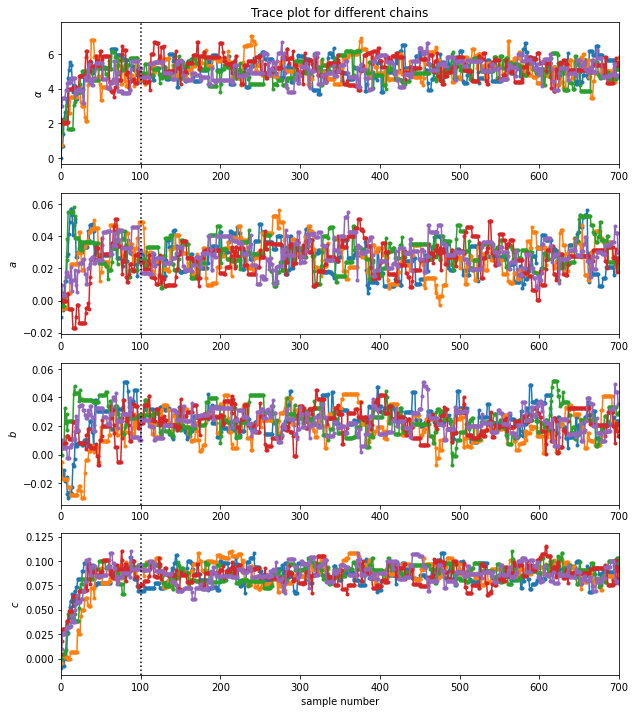

In [32]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(10,12))

ax0.set_xlim(0,700)
ax0.set_ylabel("$\\alpha$")
for samples in chains_nuisance:
    ax0.plot(np.arange(Ntries3+1),samples[1].T[0],marker='.')
ax0.axvline(Nburnin,color='black',linestyle=':')
ax0.set_title("Trace plot for different chains")

ax1.set_xlim(0,700)
ax1.set_ylabel("$a$")
for samples in chains_nuisance:
    ax1.plot(np.arange(Ntries3+1),samples[1].T[1],marker='.')
ax1.axvline(Nburnin,color='black',linestyle=':')

ax2.set_xlim(0,700)
ax2.set_ylabel("$b$")
for samples in chains_nuisance:
    ax2.plot(np.arange(Ntries3+1),samples[1].T[2],marker='.')
ax2.axvline(Nburnin,color='black',linestyle=':')

ax3.set_xlim(0,700)
ax3.set_ylabel("$c$")
ax3.set_xlabel("sample number")
for samples in chains_nuisance:
    ax3.plot(np.arange(Ntries3+1),samples[1].T[3],marker='.')
ax3.axvline(Nburnin,color='black',linestyle=':')

In [33]:
gelman_rubin(chain_nuisance)

array([1.00084861, 1.00088808, 1.00064766, 1.00068058])

In [34]:
# Remove burn-in phase
chain_nuisance_burn = np.array([chains_nuisance[j][1][Nburnin:] for j in range(Nchains)])
chain_nuisance_burn_flat = np.concatenate(chain_nuisance_burn, axis=0)

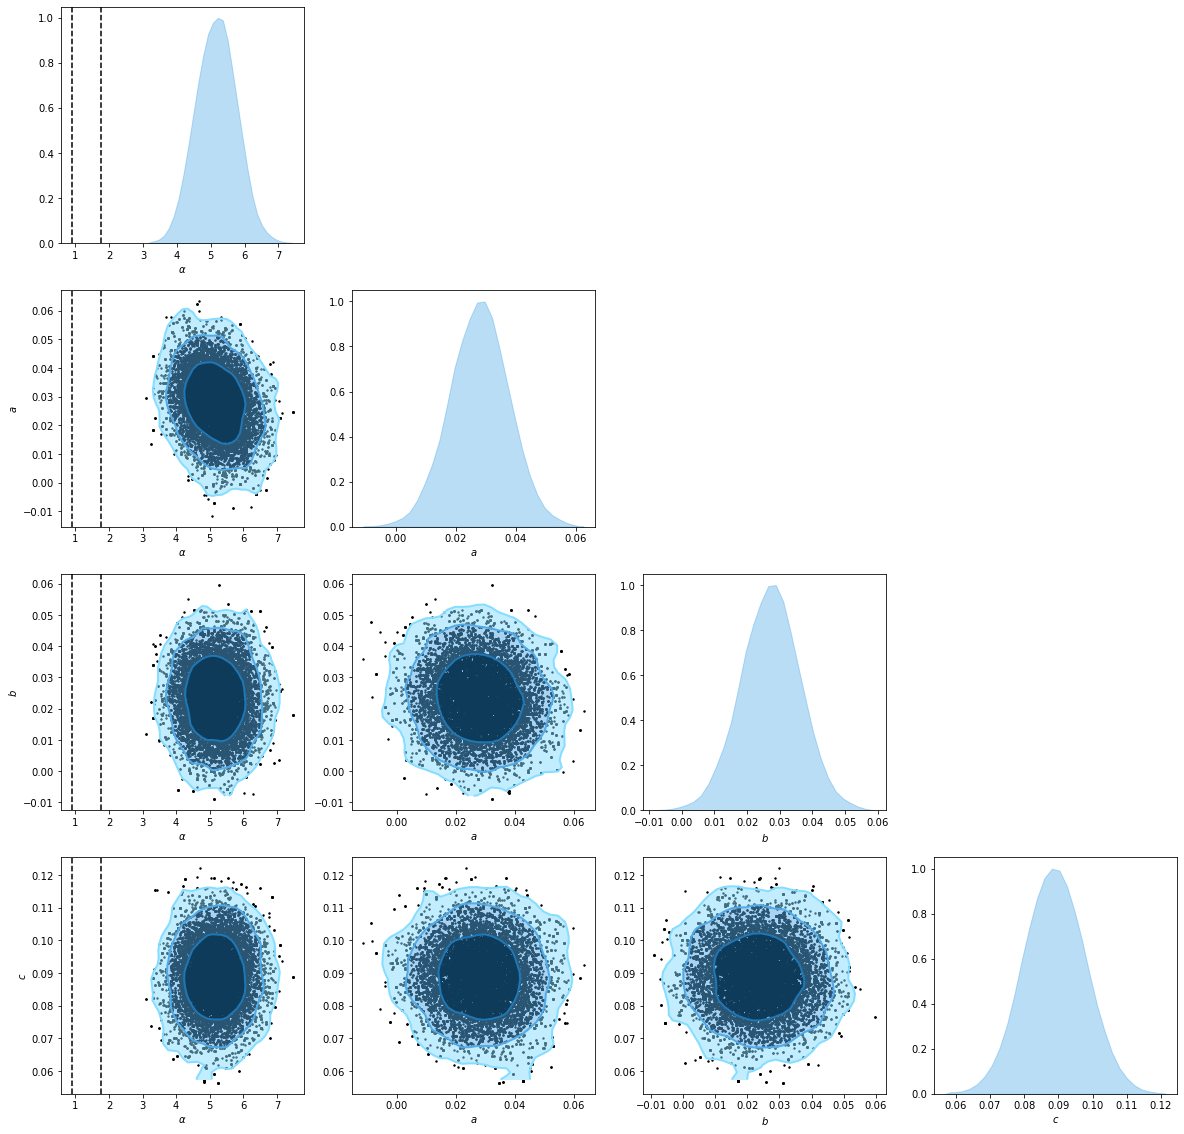

In [35]:
fig = plt.figure(figsize=(20,20))

# Plot 1d marginal distributions
ax0 = fig.add_subplot(4,4,1)
pdf_alpha = get_marginal(chain_nuisance_burn_flat.T[0])
ax0.fill_between(pdf_alpha[0],pdf_alpha[1], 0, color='#52aae7', alpha=0.4)
ax0.set_ylim(0.,pdf_alpha[1].max()*1.05)
ax0.axvline(alpha_GR,color='black',linestyle='--')
ax0.axvline(alpha_Newton,color='black',linestyle='--')
ax0.set_xlabel("$\\alpha$")

ax1 = fig.add_subplot(4,4,6)
pdf_a = get_marginal(chain_nuisance_burn_flat.T[1])
ax1.fill_between(pdf_a[0],pdf_a[1], 0, color='#52aae7', alpha=0.4)
ax1.set_ylim(0.,pdf_a[1].max()*1.05)
ax1.set_xlabel("$a$")

ax2 = fig.add_subplot(4,4,11)
pdf_b = get_marginal(chain_nuisance_burn_flat.T[2])
ax2.fill_between(pdf_b[0],pdf_a[1], 0, color='#52aae7', alpha=0.4)
ax2.set_ylim(0.,pdf_b[1].max()*1.05)
ax2.set_xlabel("$b$")

ax3 = fig.add_subplot(4,4,16)
pdf_c = get_marginal(chain_nuisance_burn_flat.T[3])
ax3.fill_between(pdf_c[0],pdf_c[1], 0, color='#52aae7', alpha=0.4)
ax3.set_ylim(0.,pdf_c[1].max()*1.05)
ax3.set_xlabel("$c$")

# Plot 2d contours
ax0a = fig.add_subplot(4,4,5)
ax0a.scatter(chain_nuisance_burn_flat.T[0], chain_nuisance_burn_flat.T[1], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_nuisance_burn_flat.T[0], chain_nuisance_burn_flat.T[1])
ax0a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax0a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax0a.axvline(alpha_GR,color='black',linestyle='--')
ax0a.axvline(alpha_Newton,color='black',linestyle='--')
ax0a.set_xlabel("$\\alpha$")
ax0a.set_ylabel("$a$")

ax1a = fig.add_subplot(4,4,9)
ax1a.scatter(chain_nuisance_burn_flat.T[0], chain_nuisance_burn_flat.T[2], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_nuisance_burn_flat.T[0], chain_nuisance_burn_flat.T[2])
ax1a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax1a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax1a.axvline(alpha_GR,color='black',linestyle='--')
ax1a.axvline(alpha_Newton,color='black',linestyle='--')
ax1a.set_xlabel("$\\alpha$")
ax1a.set_ylabel("$b$")

ax1b = fig.add_subplot(4,4,10)
ax1b.scatter(chain_nuisance_burn_flat.T[1], chain_nuisance_burn_flat.T[2], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_nuisance_burn_flat.T[1], chain_nuisance_burn_flat.T[2])
ax1b.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax1b.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax1b.set_xlabel("$a$")

ax2a = fig.add_subplot(4,4,13)
ax2a.scatter(chain_nuisance_burn_flat.T[0], chain_nuisance_burn_flat.T[3], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_nuisance_burn_flat.T[0], chain_nuisance_burn_flat.T[3])
ax2a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax2a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax2a.axvline(alpha_GR,color='black',linestyle='--')
ax2a.axvline(alpha_Newton,color='black',linestyle='--')
ax2a.set_xlabel("$\\alpha$")
ax2a.set_ylabel("$c$")

ax2b = fig.add_subplot(4,4,14)
ax2b.scatter(chain_nuisance_burn_flat.T[1], chain_nuisance_burn_flat.T[3], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_nuisance_burn_flat.T[1], chain_nuisance_burn_flat.T[3])
ax2b.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax2b.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax2b.set_xlabel("$a$")

ax2c = fig.add_subplot(4,4,15)
ax2c.scatter(chain_nuisance_burn_flat.T[2], chain_nuisance_burn_flat.T[3], color="black", s=2)
xbins, ybins, contours, chainLevels = get_contours(chain_nuisance_burn_flat.T[2], chain_nuisance_burn_flat.T[3])
ax2c.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax2c.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax2c.set_xlabel("$b$")

plt.show()

The GR value of $\alpha=1.75$ is excluded with this prior on nuisance parameters!<br/>
Also, the posterior for $c$ largely excludes the prior mean ($c=0$), which is usually the sign of an issue in the analysis.

## Use of more data

In [36]:
def target_logpdf(theta,data,sigma_d):
    return lh_platex_logpdf(theta,data,sigma_d)

In [37]:
Ntries3=5000
Nburnin=200
proposal_sigma=np.array([8e-1,1e-2,1e-2,1e-2])
proposal_cov=np.diag(proposal_sigma**2)
Nchains=5

In [38]:
# Run Nchains different chains starting at different positions in parameter space
chains_dx = [MH_sampler(Ntries3,theta_start,[dx_I,dx_II,dx_III,dx_IV,dx_V,dx_VII,dx_VIII],sigma_d,proposal_cov)
          for theta_start in np.stack((np.linspace(0.,3.,Nchains),
                                       np.linspace(-1e-2,1e-2,Nchains),
                                       np.linspace(-1e-2,1e-2,Nchains),
                                       np.linspace(-1e-2,1e-2,Nchains)),axis=1)]
chain_dx = np.array([chains_dx[j][1] for j in range(Nchains)])

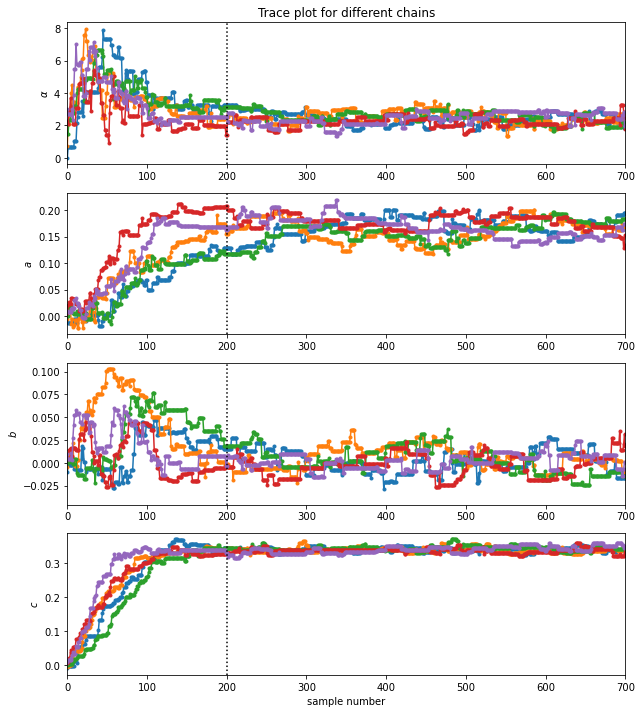

In [39]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(10,12))

ax0.set_xlim(0,700)
ax0.set_ylabel("$\\alpha$")
for samples in chains_dx:
    ax0.plot(np.arange(Ntries3+1),samples[1].T[0],marker='.')
ax0.axvline(Nburnin,color='black',linestyle=':')
ax0.set_title("Trace plot for different chains")

ax1.set_xlim(0,700)
ax1.set_ylabel("$a$")
for samples in chains_dx:
    ax1.plot(np.arange(Ntries3+1),samples[1].T[1],marker='.')
ax1.axvline(Nburnin,color='black',linestyle=':')

ax2.set_xlim(0,700)
ax2.set_ylabel("$b$")
for samples in chains_dx:
    ax2.plot(np.arange(Ntries3+1),samples[1].T[2],marker='.')
ax2.axvline(Nburnin,color='black',linestyle=':')

ax3.set_xlim(0,700)
ax3.set_ylabel("$c$")
ax3.set_xlabel("sample number")
for samples in chains_dx:
    ax3.plot(np.arange(Ntries3+1),samples[1].T[3],marker='.')
ax3.axvline(Nburnin,color='black',linestyle=':')

In [40]:
gelman_rubin(chain_dx)

array([1.00368251, 1.0029156 , 1.00939246, 1.0007683 ])

In [41]:
# Remove burn-in phase
chain_dx_burn = np.array([chains_dx[j][1][Nburnin:] for j in range(Nchains)])
chain_dx_burn_flat = np.concatenate(chain_dx_burn, axis=0)

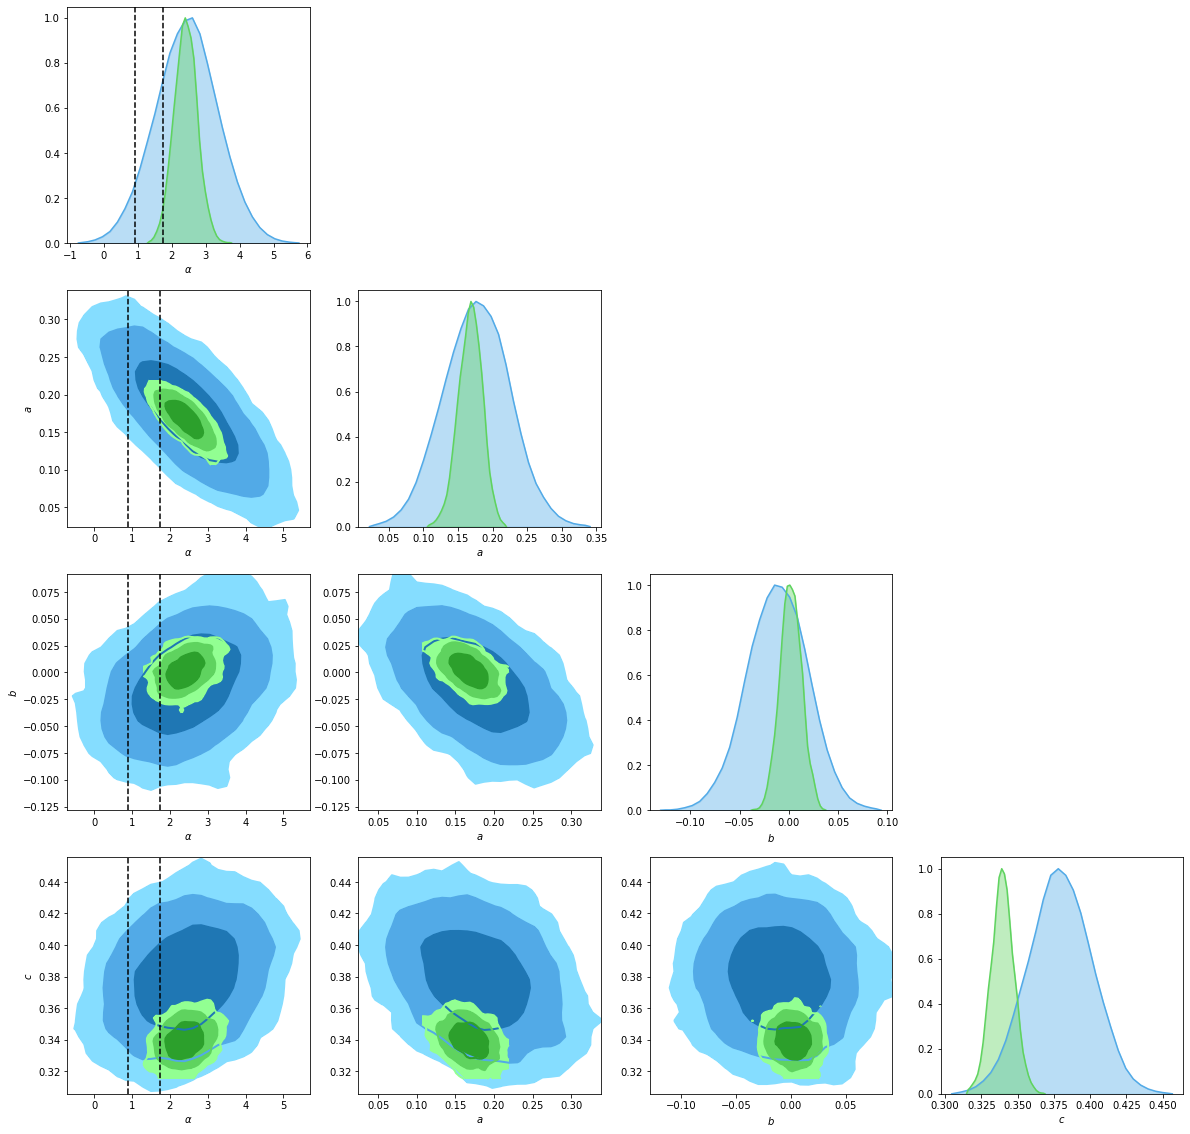

In [42]:
fig = plt.figure(figsize=(20,20))

# Plot 1d marginal distributions
ax0 = fig.add_subplot(4,4,1)
pdf_alpha_0 = get_marginal(chain_dx_II_burn_flat.T[0])
ax0.plot(pdf_alpha_0[0],pdf_alpha_0[1], color='#52aae7')
ax0.fill_between(pdf_alpha_0[0],pdf_alpha_0[1], 0, color='#52aae7', alpha=0.4)
pdf_alpha_1 = get_marginal(chain_dx_burn_flat.T[0])
ax0.plot(pdf_alpha_1[0],pdf_alpha_1[1], color='#5fd35f')
ax0.fill_between(pdf_alpha_1[0],pdf_alpha_1[1], 0, color='#5fd35f', alpha=0.4)
ax0.set_ylim(0.,pdf_alpha[1].max()*1.05)
ax0.axvline(alpha_GR,color='black',linestyle='--')
ax0.axvline(alpha_Newton,color='black',linestyle='--')
ax0.set_xlabel("$\\alpha$")

ax1 = fig.add_subplot(4,4,6)
pdf_a_0 = get_marginal(chain_dx_II_burn_flat.T[1])
ax1.plot(pdf_a_0[0],pdf_a_0[1], color='#52aae7')
ax1.fill_between(pdf_a_0[0],pdf_a_0[1], 0, color='#52aae7', alpha=0.4)
pdf_a_1 = get_marginal(chain_dx_burn_flat.T[1])
ax1.plot(pdf_a_1[0],pdf_a_1[1], color='#5fd35f')
ax1.fill_between(pdf_a_1[0],pdf_a_1[1], 0, color='#5fd35f', alpha=0.4)
ax1.set_ylim(0.,pdf_a[1].max()*1.05)
ax1.set_xlabel("$a$")

ax2 = fig.add_subplot(4,4,11)
pdf_b_0 = get_marginal(chain_dx_II_burn_flat.T[2])
ax2.plot(pdf_b_0[0],pdf_b_0[1], color='#52aae7')
ax2.fill_between(pdf_b_0[0],pdf_b_0[1], 0, color='#52aae7', alpha=0.4)
pdf_b_1 = get_marginal(chain_dx_burn_flat.T[2])
ax2.plot(pdf_b_1[0],pdf_b_1[1], color='#5fd35f')
ax2.fill_between(pdf_b_1[0],pdf_b_1[1], 0, color='#5fd35f', alpha=0.4)
ax2.set_ylim(0.,pdf_b[1].max()*1.05)
ax2.set_xlabel("$b$")

ax3 = fig.add_subplot(4,4,16)
pdf_c_0 = get_marginal(chain_dx_II_burn_flat.T[3])
ax3.plot(pdf_c_0[0],pdf_c_0[1], color='#52aae7')
ax3.fill_between(pdf_c_0[0],pdf_c_0[1], 0, color='#52aae7', alpha=0.4)
pdf_c_1 = get_marginal(chain_dx_burn_flat.T[3])
ax3.plot(pdf_c_1[0],pdf_c_1[1], color='#5fd35f')
ax3.fill_between(pdf_c_1[0],pdf_c_1[1], 0, color='#5fd35f', alpha=0.4)
ax3.set_ylim(0.,pdf_c[1].max()*1.05)
ax3.set_xlabel("$c$")

# Plot 2d contours
ax0a = fig.add_subplot(4,4,5)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[0], chain_dx_II_burn_flat.T[1])
ax0a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'))
ax0a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_burn_flat.T[0], chain_dx_burn_flat.T[1])
ax0a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'))
ax0a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'), linewidths=2)
ax0a.axvline(alpha_GR,color='black',linestyle='--')
ax0a.axvline(alpha_Newton,color='black',linestyle='--')
ax0a.set_xlabel("$\\alpha$")
ax0a.set_ylabel("$a$")

ax1a = fig.add_subplot(4,4,9)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[0], chain_dx_II_burn_flat.T[2])
ax1a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'))
ax1a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_burn_flat.T[0], chain_dx_burn_flat.T[2])
ax1a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'))
ax1a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'), linewidths=2)
ax1a.axvline(alpha_GR,color='black',linestyle='--')
ax1a.axvline(alpha_Newton,color='black',linestyle='--')
ax1a.set_xlabel("$\\alpha$")
ax1a.set_ylabel("$b$")

ax1b = fig.add_subplot(4,4,10)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[1], chain_dx_II_burn_flat.T[2])
ax1b.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'))
ax1b.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_burn_flat.T[1], chain_dx_burn_flat.T[2])
ax1b.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'))
ax1b.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'), linewidths=2)
ax1b.set_xlabel("$a$")

ax2a = fig.add_subplot(4,4,13)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[0], chain_dx_II_burn_flat.T[3])
ax2a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'))
ax2a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_burn_flat.T[0], chain_dx_burn_flat.T[3])
ax2a.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'))
ax2a.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'), linewidths=2)
ax2a.axvline(alpha_GR,color='black',linestyle='--')
ax2a.axvline(alpha_Newton,color='black',linestyle='--')
ax2a.set_xlabel("$\\alpha$")
ax2a.set_ylabel("$c$")

ax2b = fig.add_subplot(4,4,14)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[1], chain_dx_II_burn_flat.T[3])
ax2b.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'))
ax2b.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_burn_flat.T[1], chain_dx_burn_flat.T[3])
ax2b.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'))
ax2b.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'), linewidths=2)
ax2b.set_xlabel("$a$")

ax2c = fig.add_subplot(4,4,15)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_II_burn_flat.T[2], chain_dx_II_burn_flat.T[3])
ax2c.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'))
ax2c.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
xbins, ybins, contours, chainLevels = get_contours(chain_dx_burn_flat.T[2], chain_dx_burn_flat.T[3])
ax2c.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'))
ax2c.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#92ff92','#5fd35f','#2ca02c'), linewidths=2)
ax2c.set_xlabel("$b$")

plt.show()

## Model comparison

We will compute the Bayes factor (for non-committal priors on the models):

$
\mathcal{B} = \dfrac{p(\alpha_\mathrm{GR}|d)}{p(\alpha_\mathrm{Newton}|d)} = \dfrac{p(d|\alpha_\mathrm{GR})}{p(d|\alpha_\mathrm{Newton})}
$

To compute the evidence $p(d|\alpha)$ in each case, we marginalise the likelihood over the nuisance parameters $\psi = (a,b,c)$:

$
p(d|\alpha) = \int p(d,\psi|\alpha) \; \mathrm{d}\psi = \int p(d|\alpha,\psi) p(\psi) \; \mathrm{d}\psi = \left\langle p(d|\alpha,\psi )\right\rangle_{p(\psi)}.
$

### 1- Monte Carlo integration

Since the integral is sufficiently low-dimensional (3d), it could be evaluated on a grid. An alternative is to evaluate it by Monte-Carlo integration: for a set of $N$ samples $\psi_i$ drawn from the prior $p(\psi)$, we have

$
\left\langle p(d|\alpha,\psi )\right\rangle_{p(\psi)} \approx \dfrac{1}{N} \sum_{i=1}^N p(d|\alpha,\psi_i)
$

In [43]:
def psi_prior_pdf():
    return ss.multivariate_normal([0.,0.,0.],np.diag(np.array([0.2,0.1,0.2])**2))

In [44]:
def get_evidence_MC(alpha,data,sigma_d,Nsamp):
    # Draw a set of samples of nuisance parameters from a prior
    samples = psi_prior_pdf().rvs(Nsamp)
    
    # Compute the integral
    target_pdf = np.exp([lh_platex_logpdf([alpha,a,b,c],data,sigma_d) for (a,b,c) in samples])
    
    StandardMonteCarloI = np.average(target_pdf)
    return StandardMonteCarloI

In [45]:
# We need enough samples to get a good estimate of the integrals
get_evidence_MC(alpha_GR,[dx_II],sigma_d,500),\
get_evidence_MC(alpha_GR,[dx_II],sigma_d,20000),\
get_evidence_MC(alpha_GR,[dx_II],sigma_d,50000),\
get_evidence_MC(alpha_GR,[dx_II],sigma_d,100000)

(3.07569064025609e-05,
 0.000177481374277382,
 0.00012466871801419674,
 0.000152511176697382)

In [46]:
# We then get an estimate of the Bayes factor (which still scatters quite a lot)
get_evidence_MC(alpha_GR,[dx_II],sigma_d,50000)/get_evidence_MC(alpha_Newton,[dx_II],sigma_d,50000),\
get_evidence_MC(alpha_GR,[dx_II],sigma_d,50000)/get_evidence_MC(alpha_Newton,[dx_II],sigma_d,50000),\
get_evidence_MC(alpha_GR,[dx_II],sigma_d,50000)/get_evidence_MC(alpha_Newton,[dx_II],sigma_d,50000)

(3.9379225494095196, 3.4810688512889505, 3.7780271680231174)

### 2- Importance sampling

Possible improvements of this simple Monte-Carlo integration include importance sampling. We draw samples from a proposal pdf, designed to be as close as possible to the target pdf. We then assign each sample a weight proportional to its likelihood divided by its proposal probability. In this case, we use a Gaussian fit to the posterior on $\psi$ (marginalised over $\alpha$, i.e. $p(\psi|d)$) as proposal pdf.

In [47]:
def get_evidence_IS(alpha,proposal_mean,proposal_cov,data,sigma_d,Nsamp):
    # Draw a set of samples of nuisance parameters from the proposal pdf
    samples = ss.multivariate_normal(proposal_mean, proposal_cov).rvs(Nsamp)
    
    # Compute the integrand and weights
    target_pdf = np.exp([lh_platex_logpdf([alpha,a,b,c],data,sigma_d) for (a,b,c) in samples])
    proposal_pdf = ss.multivariate_normal(proposal_mean, proposal_cov).pdf(samples)
    prior_pdf = psi_prior_pdf().pdf(samples)
    weights = prior_pdf/proposal_pdf
    
    # Compute the integral
    ImportanceSamplingI = np.average(target_pdf,weights=weights)
    return ImportanceSamplingI

In [48]:
proposal_mean, proposal_cov = np.mean(chain_dx_II_burn_flat, axis=0)[1:], 10*np.cov(chain_dx_II_burn_flat[:,1:].T)
proposal_mean, proposal_cov

(array([ 0.17707015, -0.01130455,  0.37931725]),
 array([[ 0.02158136, -0.0075217 , -0.00319013],
        [-0.0075217 ,  0.00883052, -0.00033117],
        [-0.00319013, -0.00033117,  0.00452375]]))

In [49]:
# We need enough samples to get a good estimate of the integrals
get_evidence_IS(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,500),\
get_evidence_IS(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,20000),\
get_evidence_IS(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,50000),\
get_evidence_IS(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,100000)

(0.000538038020333599,
 0.00025019867404066625,
 0.00045296640866673436,
 0.0005568685964084196)

In [50]:
# We get a better estimate of the Bayes factor
get_evidence_IS(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,50000)\
    /get_evidence_IS(alpha_Newton,proposal_mean,proposal_cov,[dx_II],sigma_d,50000),\
get_evidence_IS(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,50000)\
    /get_evidence_IS(alpha_Newton,proposal_mean,proposal_cov,[dx_II],sigma_d,50000),\
get_evidence_IS(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,50000)\
    /get_evidence_IS(alpha_Newton,proposal_mean,proposal_cov,[dx_II],sigma_d,50000)

(2.716454903975526, 4.588252773778886, 4.6994741271708245)

### 3- Importance resampling

A problem with importance sampling is the situation in which all but one of the weights are close to zero. To avoid with situation, we can do **importance resampling**. We draw Nresamp new samples from the current sample set with probabilities proportional to their weights. We replace the current samples with this new set, and the the current weights by 1/Nresamp (drawing according to the importance weight replaces likelihoods by frequencies). Weights are then updated given their likelihood, as in the previous importance sampling step.

In [51]:
def get_evidence_IR(alpha,proposal_mean,proposal_cov,data,sigma_d,Nsamp,Nresamp):
    # Draw a set of samples of nuisance parameters from the proposal pdf
    samples = ss.multivariate_normal(proposal_mean, proposal_cov).rvs(Nsamp)
    
    # Compute the integrand and weights
    target_pdf = np.exp([lh_platex_logpdf([alpha,a,b,c],data,sigma_d) for (a,b,c) in samples])
    proposal_pdf = ss.multivariate_normal(proposal_mean, proposal_cov).pdf(samples)
    weights = 1./proposal_pdf
    
    # Resample
    normalizedweights=weights/np.sum(weights)
    rows=np.random.choice(np.arange(Nsamp), size=Nresamp, replace=True, p=normalizedweights)
    resamples=samples[rows,:]
    reweights=1./Nresamp*np.ones(Nresamp)
    
    # Weight the resamples according to their likelihood
    reweights*=np.exp([lh_platex_logpdf([alpha,a,b,c],data,sigma_d) for (a,b,c) in resamples])/(1./Nresamp)
    
    # Compute the integral
    ImportanceReI=np.sum(reweights)/Nresamp
    return ImportanceReI

In [52]:
# We need enough samples to get a good estimate of the integrals
get_evidence_IR(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,500,250),\
get_evidence_IR(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,20000,10000),\
get_evidence_IR(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,50000,25000),\
get_evidence_IR(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,100000,50000)

(6.611203944863593e-07,
 0.0002476118580704786,
 0.0003649026039848957,
 0.00022410614451559042)

In [53]:
# We get an estimate of the Bayes factor
get_evidence_IR(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,50000,25000)\
    /get_evidence_IR(alpha_Newton,proposal_mean,proposal_cov,[dx_II],sigma_d,50000,25000),\
get_evidence_IR(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,50000,25000)\
    /get_evidence_IR(alpha_Newton,proposal_mean,proposal_cov,[dx_II],sigma_d,50000,25000),\
get_evidence_IR(alpha_GR,proposal_mean,proposal_cov,[dx_II],sigma_d,50000,25000)\
    /get_evidence_IR(alpha_Newton,proposal_mean,proposal_cov,[dx_II],sigma_d,50000,25000)

(3.516330918881818, 4.825466101131329, 4.240512496611078)